In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
df_begin = pd.read_csv(r"C:\Users\giorgio1\OneDrive - Universita degli Studi di Milano-Bicocca\Decision Models\Progetto\Dataset\total_district.txt",
                      names=['taxi_id','date_time','long','lat','district'])
df_begin['datetime'] = pd.to_datetime(df_begin['date_time'],format = '%Y-%m-%d %X')
df_begin = df_begin.set_index('datetime')
df_begin.drop(['long','lat','date_time'], axis = 1, inplace = True)
print(df_begin.head())

                     taxi_id  district
datetime                              
2008-02-02 15:36:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:56:08        1  Chaoyang
2008-02-02 16:06:08        1  Chaoyang
Wall time: 1min 9s


In [3]:
%%time
#Prevision for every 10 minutes
df = df_begin.groupby([pd.Grouper(level='datetime', freq='10Min'),
                      "district"])[['taxi_id']].count().reset_index()

Wall time: 8.74 s


In [4]:
df.datetime = pd.to_datetime(df.datetime,format = '%Y-%m-%d %X')
df.columns=['datetime','district','taxi_count']

In [5]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

In [6]:
res = requests.get("https://www.sunrise-and-sunset.com/en/sun/china/beijing/2008/february/2")
soup = BeautifulSoup(res.content,'lxml')
all_tables=soup.find_all("table")

In [7]:
df_sunrise = pd.read_html(str(all_tables[1]))[0][1:8].reset_index()
df_sunrise.drop('index',axis=1,inplace=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Lenght"]

C:\Users\giorgio1\Anaconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [8]:
df_sunrise = pd.concat([df_sunrise,pd.DataFrame([day.split(',') for day in df_sunrise.Day])],
                        axis=1,ignore_index=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Length","Date","WeekDay"]
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

In [9]:
def weekday(x):
    app = str(x)
    #ipdb.set_trace()
    if(app == "2008-02-02"):
        return "Saturday"
    if(app == "2008-02-03"):
        return "Sunday"
    if(app == "2008-02-04"):
        return "Monday"
    if(app == "2008-02-05"):
        return "Tuesday"
    if(app == "2008-02-06"):
        return "Wednesday"
    if(app == "2008-02-07"):
        return "Thursday"
    if(app == "2008-02-08"):
        return "Friday"
    
def working_or_not(x):
    # 0 --> day off, 1 --> day on
    app = str(x)
    #ipdb.set_trace()
    if(app == "2008-02-02"):
        return 0
    if(app == "2008-02-03"):
        return 0
    if(app == "2008-02-04"):
        return 1
    if(app == "2008-02-05"):
        return 1
    if(app == "2008-02-06"):
        return 0
    if(app == "2008-02-07"):
        return 0
    if(app == "2008-02-08"):
        return 0

def is_sun_up(data,sunrise_table):
    detail  = sunrise_table[data.date()==sunrise_table.Date.dt.date].reset_index()
    sunrise = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunrise'])
    sunset  = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunset'])
    if ((sunrise < data) & (data < sunset))[0]:
        return 1
    else:
        return 0

def is_time_to_eat(time):
    hour = time.hour
    if(6<=hour<=9 or 12<=hour<=14 or 18<=hour<=21):
        return 1 #yes
    else:
        return 0 #no

In [10]:
%%time
from math import pi
df['Weekday'] = df.datetime.dt.date.apply(weekday)
df['working_or_not'] = df.datetime.dt.date.apply(working_or_not)
df["is_sun_up"]  = df.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
df["time_to_eat"] = df.datetime.apply(is_time_to_eat)
df['sin_frequency'] = np.sin(pi*np.array(df.datetime.dt.hour)/24)

Wall time: 1min 17s


In [11]:

%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
df2 = df.copy()

In [193]:
prova = df2.groupby("datetime")[["taxi_count"]].sum()

In [194]:
for i in range(1,25):
    sf = "sin_frequency_{0}".format(i)
    prova[sf] = np.sin(pi*np.array(prova.index.hour)/i)

In [195]:
#prova['sin_frequency'] = np.sin(pi*np.array(prova.index.hour)/12)
#prova['sin_frequency24']= np.sin(pi*np.array(prova.index.hour)/24)

In [196]:
for i in range(1,7):
    sh = "shift_{0}".format(i)
    prova[sh] = prova.taxi_count.shift(i)

In [197]:
prova["shift_12"] = prova.taxi_count.shift(12)
prova["shift_24"] = prova.taxi_count.shift(24)

In [198]:
prova

,taxi_count,sin_frequency_1,sin_frequency_2,sin_frequency_3,sin_frequency_4,sin_frequency_5,sin_frequency_6,sin_frequency_7,sin_frequency_8,sin_frequency_9,...,sin_frequency_23,sin_frequency_24,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_12,shift_24
datetime,,,,,,,,,,,,,,,,,,,,,
2008-02-02 13:30:00,19721,-1.960673e-15,1.000000e+00,8.660254e-01,-7.071068e-01,9.510565e-01,5.000000e-01,-4.338837e-01,-9.238795e-01,-9.848078e-01,...,0.979084,0.991445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-02 13:40:00,28444,-1.960673e-15,1.000000e+00,8.660254e-01,-7.071068e-01,9.510565e-01,5.000000e-01,-4.338837e-01,-9.238795e-01,-9.848078e-01,...,0.979084,0.991445,19721.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-02 13:50:00,28627,-1.960673e-15,1.000000e+00,8.660254e-01,-7.071068e-01,9.510565e-01,5.000000e-01,-4.338837e-01,-9.238795e-01,-9.848078e-01,...,0.979084,0.991445,28444.0,19721.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-02 14:00:00,25055,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,28627.0,28444.0,19721.0,NaN,NaN,NaN,NaN,NaN
2008-02-02 14:10:00,24114,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,25055.0,28627.0,28444.0,19721.0,NaN,NaN,NaN,NaN
2008-02-02 14:20:00,25414,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,24114.0,25055.0,28627.0,28444.0,19721.0,NaN,NaN,NaN
2008-02-02 14:30:00,25450,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,25414.0,24114.0,25055.0,28627.0,28444.0,19721.0,NaN,NaN
2008-02-02 14:40:00,24255,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,25450.0,25414.0,24114.0,25055.0,28627.0,28444.0,NaN,NaN
2008-02-02 14:50:00,24671,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,24255.0,25450.0,25414.0,24114.0,25055.0,28627.0,NaN,NaN


In [199]:
prova.dropna(inplace = True)

In [200]:
prova.reset_index(inplace = True)

In [201]:
prova['Weekday'] = prova.datetime.dt.date.apply(weekday)
prova['working_or_not'] = prova.datetime.dt.date.apply(working_or_not)
prova["is_sun_up"]  = prova.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
prova["time_to_eat"] = prova.datetime.apply(is_time_to_eat)
#prova['sin_frequency'] = np.sin(pi*np.array(df.datetime.dt.hour)/12)

In [202]:
prova.drop("datetime", axis = 1,inplace = True)

In [203]:
prova = pd.get_dummies(prova,columns=['Weekday'])

In [204]:
Y = prova["taxi_count"].values
X = prova.drop(['taxi_count'], axis = 1).values
display(X)
display(Y)

array([[-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

array([25228, 26383, 24781, 25488, 24913, 24911, 25687, 27271, 24935,
       28155, 28155, 28500, 28800, 26987, 28439, 29643, 27547, 27173,
       25860, 27787, 25746, 23847, 25002, 23981, 26202, 24437, 23565,
       22667, 24576, 22768, 23925, 23996, 24137, 23259, 22002, 21052,
       22027, 21243, 20259, 20450, 19271, 19988, 19992, 19335, 19931,
       20927, 18892, 19445, 19581, 16369, 17552,  8243,  8683,  8125,
       16330, 16376, 17535, 16371, 15365, 14861, 11835, 11641, 12062,
       11857, 13046, 15001, 13917, 13101, 14936, 14016, 14207, 13953,
       13403, 13357, 12293, 13295, 13146, 13151, 12281, 14042, 13017,
       14233, 11270, 10657, 11810, 12382, 12058, 12913, 13647,  7093,
        7342, 14814, 14443, 14576, 17099, 15788, 19902, 21229, 20012,
       20716, 21556, 23205, 22163, 21866, 23338, 20829, 22877, 24652,
       23991, 24121, 24506, 22983, 21288, 19503, 25038, 26582, 26663,
       28230, 26348, 29137, 28083, 25654, 26979, 25923, 26564, 26380,
       28326, 26906,

# Random Forest

In [205]:
from sklearn.model_selection import train_test_split

In [206]:
X.shape

(862, 42)

In [207]:
2000/60

33.333333333333336

Prevediamo 33 ore ovvero un giorno e mezzo. 

In [208]:
x_train, x_test, y_train, y_test = X[1:662], X[662:861], Y[1:662], Y[662:861]

In [209]:
from sklearn.ensemble import RandomForestRegressor

In [210]:
rfr= RandomForestRegressor(bootstrap = False, random_state=0)
rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [211]:
y_pred = rfr.predict(x_test)

In [212]:
y_pred_train = rfr.predict(x_train)

In [213]:
# Check overfitting

In [214]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("MSE: "+str(mean_squared_error(y_test, y_pred)))
print("R-squared: "+str(r2_score(y_test, y_pred)))
print("MSE: "+str(mean_squared_error(y_train, y_pred_train)))
print("R-squared: "+str(r2_score(y_train, y_pred_train)))

MSE: 3328503.9348241217
R-squared: 0.838331498395718
MSE: 0.0
R-squared: 1.0


In [215]:
np.sqrt(mean_squared_error(y_test, y_pred))/np.mean(Y)

0.0921245781298366

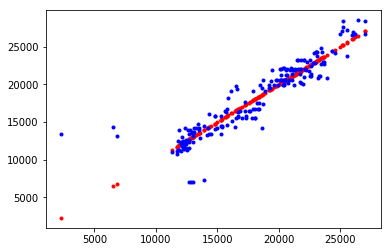

In [216]:
plt.plot(y_test,y_test,'r.')
plt.plot(y_test, y_pred,'b.')

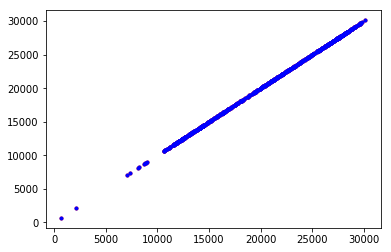

In [217]:
plt.plot(y_train,y_train,'r.')
plt.plot(y_train, y_pred_train,'b.')

# ElasticNet

In [218]:
from sklearn.linear_model import ElasticNet

In [219]:
def overfit_eval(model, X, Y):
    
    """
    model: il nostro modello predittivo già addestrato
    X: una tupla contenente le prorietà del train set e test set (X_train, X_test)
    Y: una tupla contenente target del train set e test set (Y_train, Y_test)
    """
    
    Y_pred_train = model.predict(X[0])
    Y_pred_test = model.predict(X[1])
    
    mse_train = mean_squared_error(Y[0], Y_pred_train)
    mse_test = mean_squared_error(Y[1], Y_pred_test)

    r2_train = r2_score(Y[0], Y_pred_train)
    r2_test = r2_score(Y[1], Y_pred_test)    
    
    print("Train set:  MSE="+str(mse_train)+" R2="+str(r2_train))
    print("Test set:  MSE="+str(mse_test)+" R2="+str(r2_test))

l1 ratio è il rapporto tra l1 e l2. Se l1/l2 = 0 -> la penalità è un l2. Viceversa se l1/l2 è 1 allora la penalità è un l1. 

In [220]:
alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,1] #alpha corrispone a lambda
l1_re = [0, 0.5,0.5,0.8,0.9,1]
for alpha in alphas:
        #print("Alpha="+str(alpha))
        #print("L1 ratio="+str(l1_res))
    elastic = ElasticNet(alpha=alpha, l1_ratio=1)
    elastic.fit(x_train, y_train)

    overfit_eval(elastic, (x_train, x_test),(y_train, y_test))

Train set:  MSE=2420321.469999885 R2=0.9320458123685199
Test set:  MSE=1681572.7572590904 R2=0.9183244624828653
Train set:  MSE=2420321.6355837593 R2=0.9320458077195022
Test set:  MSE=1682311.731859846 R2=0.9182885698059248
Train set:  MSE=2420325.031041465 R2=0.9320457123868892
Test set:  MSE=1695413.9677434165 R2=0.9176521821421455
Train set:  MSE=2420477.4473368484 R2=0.9320414330687643
Test set:  MSE=1781405.3815591233 R2=0.9134754999766327
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.9488985145 R2=0.9143841372101541
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.9488985145 R2=0.9143841372101541


C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

In [221]:
alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,1] #alpha corrispone a lambda
l1_re = [0, 0.5,0.5,0.8,0.9,1]
for alpha in alphas:
    for l1_res in l1_re:
        print("Lambda="+str(alpha))
        print("L1 ratio="+str(l1_res))
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1_res)
        elastic.fit(x_train, y_train)
        overfit_eval(elastic, (x_train, x_test),(y_train, y_test))

Lambda=0.0001
L1 ratio=0
Train set:  MSE=2420453.214341098 R2=0.9320421134467887
Test set:  MSE=1726302.3917311504 R2=0.9161519029414005
Lambda=0.0001
L1 ratio=0.5
Train set:  MSE=2420389.671021291 R2=0.9320438975216442
Test set:  MSE=1705865.8615423846 R2=0.9171445240343309
Lambda=0.0001
L1 ratio=0.5
Train set:  MSE=2420389.671021291 R2=0.9320438975216442
Test set:  MSE=1705865.8615423846 R2=0.9171445240343309
Lambda=0.0001
L1 ratio=0.8
Train set:  MSE=2420349.2965450697 R2=0.9320450310961576
Test set:  MSE=1690152.0261359122 R2=0.9179077594921718
Lambda=0.0001
L1 ratio=0.9
Train set:  MSE=2420335.47216051 R2=0.9320454192366727
Test set:  MSE=1685367.7765445057 R2=0.9181401349010309
Lambda=0.0001
L1 ratio=1
Train set:  MSE=2420321.469999885 R2=0.9320458123685199
Test set:  MSE=1681572.7572590904 R2=0.9183244624828653
Lambda=0.001
L1 ratio=0
Train set:  MSE=2421044.429595035 R2=0.9320255141839243
Test set:  MSE=1737871.8543791655 R2=0.9155899634853276
Lambda=0.001
L1 ratio=0.5
Train se

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2422011.4076512745 R2=0.9319983648117919
Test set:  MSE=1696402.6182033052 R2=0.9176041624787801
Lambda=0.01
L1 ratio=0.5
Train set:  MSE=2422011.4076512745 R2=0.9319983648117919
Test set:  MSE=1696402.6182033052 R2=0.9176041624787801
Lambda=0.01
L1 ratio=0.8
Train set:  MSE=2421294.21381152 R2=0.9320185011140801
Test set:  MSE=1726578.9639515313 R2=0.9161384695739387
Lambda=0.01
L1 ratio=0.9
Train set:  MSE=2421041.5626930273 R2=0.9320255946765363
Test set:  MSE=1738138.4298648438 R2=0.9155770156684772
Lambda=0.01
L1 ratio=1
Train set:  MSE=2420325.031041465 R2=0.9320457123868892
Test set:  MSE=1695413.9677434165 R2=0.9176521821421455
Lambda=0.1
L1 ratio=0
Train set:  MSE=2471249.212621955 R2=0.9306159389320016
Test set:  MSE=1378071.606568871 R2=0.9330657928907728
Lambda=0.1
L1 ratio=0.5
Train set:  MSE=2445832.046087241 R2=0.9313295643429933
Test set:  MSE=1466716.0595341786 R2=0.9287602501703646
Lambda=0.1
L1 ratio=0.5
Train set:  MSE=2445832.046087241 R2=0.93132956

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.9488985145 R2=0.9143841372101541
Lambda=1
L1 ratio=0
Train set:  MSE=2632549.9103775485 R2=0.9260871777669103
Test set:  MSE=1294950.211511744 R2=0.9371030756019478
Lambda=1
L1 ratio=0.5
Train set:  MSE=2577210.26368829 R2=0.927640922086082
Test set:  MSE=1284040.616494409 R2=0.9376329646794728
Lambda=1
L1 ratio=0.5
Train set:  MSE=2577210.26368829 R2=0.927640922086082
Test set:  MSE=1284040.616494409 R2=0.9376329646794728
Lambda=1
L1 ratio=0.8
Train set:  MSE=2511110.392723232 R2=0.9294967759838605
Test set:  MSE=1313220.2928779826 R2=0.9362156809235864
Lambda=1
L1 ratio=0.9
Train set:  MSE=2473716.6305129835 R2=0.9305466624410847
Test set:  MSE=1374784.9786688478 R2=0.9332254274347999
Lambda=1
L1 ratio=1
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.9488985145 R2=0.9143841372101541


C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Dai risultati emerge che lambda = 0.01 e l1 ratio = 1 (penalità l1) risulta il valore ottimale

In [222]:
#GridSeach CV for Random Forest

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
#max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#Method of selecting samples for training each tree
#bootstrap = [True, False]

#Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor(bootstrap = False)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)

%%time
rf_random.fit(x_train, y_train)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = np.sqrt(mean_squared_error(y_test, predictions))
    param = model.best_params_
    estimator = model.best_estimator_
    print('Model Performance')
    print('MSE of: ', errors)
    print("Parameters: ", param)
    print("Estimator: ", estimator )
    
    return errors

random_accuracy = evaluate(rf_random, x_test, y_test)

y_pred_random = rf_random.predict(x_test)
y_pred_train_r = rf_random.predict(x_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("MSE: "+str(mean_squared_error(y_test, y_pred_random)))
print("R-squared: "+str(r2_score(y_test, y_pred_random)))
print("MSE: "+str(mean_squared_error(y_train, y_pred_train_r)))
print("R-squared: "+str(r2_score(y_train, y_pred_train_r)))

plt.plot(y_train,y_train,'r.')
plt.plot(y_train, y_pred_train_r,'b.')

plt.figure(figsize = (15,10))
plt.plot(y_test,'r')
plt.plot(y_pred_random,'b')

In [223]:
X_t = (X[0:800])
X_val = X[800:861]
Y_t = Y[0:800]
Y_val = Y[800:861]

# Random Forest R. CV for Time Series

In [225]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t.shape[0]-1)
y_ = []
y_pred = []
for train_index, test_index in tscv.split(X_t):
    if train_index.shape[0] > 100: #le previsioni iniziano dalla 100-esima osservazione (1000 minuti) in poi
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t[train_index], X[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t[train_index], Y_t[test_index]
        lr = RandomForestRegressor(bootstrap = False, random_state=0,
                          n_estimators = 200, min_samples_split = 5,
                           min_samples_leaf= 1, max_features = "sqrt",
                           max_depth = 15) #200 alberi, si splitta quando ci sono almeno 5 osservazioni, ci deve essere almeno 1 elemento dentro ogni foglia
        lr.fit(X_train, y_train)

    #overfit_eval(lasso, (X_train, X_test),(y_train, y_test))
        y_pred.append(lr.predict(X_test))
        y_.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

In [226]:
y_prediction = lr.predict(X_t) #predizione solo sul training set e non sul validation

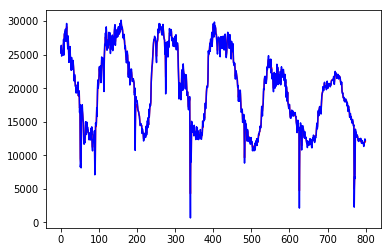

In [227]:
plt.plot(y_prediction,color="red")
plt.plot(Y_t, color= "blue")

In [228]:
r2_score(Y_t, y_prediction)

0.995441409825867

In [229]:
#validation test
y_prediction_val = lr.predict(X_val)

In [230]:
np.mean(np.abs(y_prediction_val - Y_val)/Y_val) 

0.039303367837738315

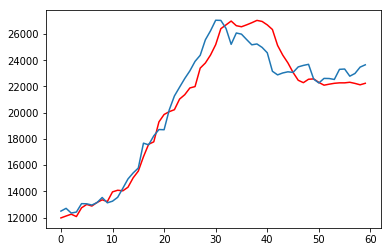

In [231]:
plt.plot(y_prediction_val[0:Y_val.shape[0]-1],color="red")
plt.plot(Y_val[0:Y_val.shape[0]-1])

In [232]:
r2_score(Y_val[0:Y_val.shape[0]-1],y_prediction_val[0:Y_val.shape[0]-1]) #R^2 sul validation set

0.9458293796739026

In [233]:
prova.head(1)

,taxi_count,sin_frequency_1,sin_frequency_2,sin_frequency_3,sin_frequency_4,sin_frequency_5,sin_frequency_6,sin_frequency_7,sin_frequency_8,sin_frequency_9,...,working_or_not,is_sun_up,time_to_eat,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,25228,-1.470814e-15,1.0,-0.866025,0.707107,-0.951057,0.5,0.974928,0.382683,-0.34202,...,0,1,0,0,0,1,0,0,0,0


In [245]:
lr.feature_importances_ #le variabili importanti sono [sin_frequency, sin_frequency24, shift_12, shift_24]

array([0.00000000e+00, 3.69910948e-04, 5.53173096e-04, 1.39462252e-03,
       7.23769515e-04, 1.89632765e-03, 3.81994001e-03, 6.27564850e-03,
       1.09630286e-02, 3.20939438e-02, 5.47799951e-02, 1.12986040e-02,
       1.96198173e-02, 1.24968443e-02, 6.22883944e-03, 4.90810611e-03,
       3.92961729e-03, 4.73624236e-03, 3.16416035e-03, 3.67372841e-03,
       6.07169716e-03, 5.59059486e-03, 6.87646626e-03, 1.03706303e-02,
       1.93751198e-01, 1.65614710e-01, 1.35629465e-01, 8.69841962e-02,
       8.59914956e-02, 5.42092905e-02, 3.19306957e-02, 1.80413726e-02,
       3.39502830e-03, 8.75130832e-04, 3.24795498e-04, 5.87034126e-04,
       3.35907761e-03, 1.78059940e-04, 1.34970158e-03, 3.53687546e-03,
       1.11907873e-03, 1.28708561e-03])

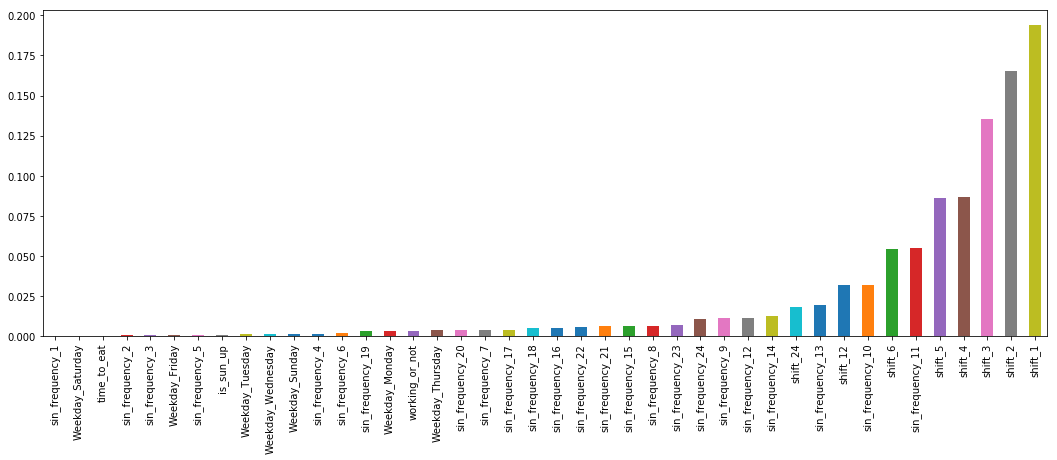

In [255]:
feature_importance = pd.Series(index = prova.columns[1:], data = lr.feature_importances_)
feature_importance.sort_values().plot(kind = 'bar', figsize = (18,6))

Proviamo con la Feature Selection e la Cross Validation

In [264]:
important_f = feature_importance.sort_values(ascending=False).head(25).index

In [269]:
df_fs = prova[important_f]

In [270]:
prova.head(1)

,taxi_count,sin_frequency_1,sin_frequency_2,sin_frequency_3,sin_frequency_4,sin_frequency_5,sin_frequency_6,sin_frequency_7,sin_frequency_8,sin_frequency_9,...,working_or_not,is_sun_up,time_to_eat,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,25228,-1.470814e-15,1.0,-0.866025,0.707107,-0.951057,0.5,0.974928,0.382683,-0.34202,...,0,1,0,0,0,1,0,0,0,0


In [271]:
df_fs['taxi_count'] = prova['taxi_count']

C:\Users\giorgio1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [272]:
Y_fs = df_fs["taxi_count"].values
X_fs = df_fs.drop(['taxi_count'], axis = 1).values

In [273]:
X_t_fs = X_fs[0:800]
X_val_fs = X_fs[800:861]
Y_t_fs = Y_fs[0:800]
Y_val_fs = Y_fs[800:861]

In [274]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t_fs.shape[0]-1)
y_3 = []
y_pred3 = []
for train_index, test_index in tscv.split(X_t_fs):
    if train_index.shape[0] > 100:
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t_fs[train_index], X_fs[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t_fs[train_index], Y_t_fs[test_index]
        lr3 = RandomForestRegressor(bootstrap = False, random_state=0,
                          n_estimators = 100, min_samples_split = 100,
                           min_samples_leaf= 70, max_features="sqrt")
        lr3.fit(X_t_fs, Y_t_fs)

   
        y_pred3.append(lr3.predict(X_test))
        y_3.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

In [275]:
y_prediction5 = lr3.predict(X_t_fs)

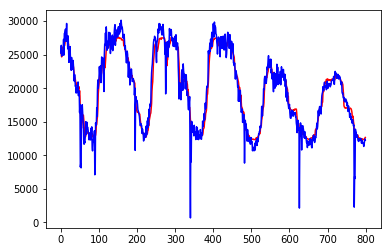

In [276]:
plt.plot(y_prediction5,color="red")
plt.plot(Y_t_fs, color= "blue")

In [277]:
r2_score(Y_t_fs, y_prediction5)

0.9180349907153187

In [278]:
y_pred5_v = lr3.predict(X_val_fs)

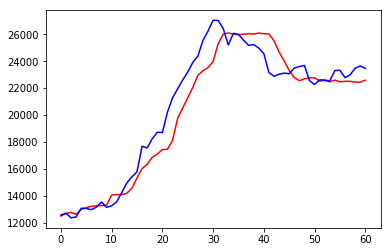

In [279]:
plt.plot(y_pred5_v,color="red")
plt.plot(Y_val_fs, color= "blue")

In [280]:
r2_score(Y_val_fs, y_pred5_v)

0.9222393345693617

# Elastic Net CV for TimeSeries

In [281]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t.shape[0]-1)
y_ = []
y_pred = []
#alphas = [0.0001, 0.001, 0.01, 0.1] #alpha corrispone a lambda

for train_index, test_index in tscv.split(X_t):
    if train_index.shape[0] > 100:
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t[train_index], X[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t[train_index], Y_t[test_index]
        #for alpha in alphas:
        elastic = ElasticNet(alpha=0.01, l1_ratio=1)
        elastic.fit(X_train, y_train)
        #print(overfit_eval(elastic, (X_train, X_test),(y_train, y_test)))
    #overfit_eval(lasso, (X_train, X_test),(y_train, y_test))
        y_pred.append(elastic.predict(X_test))
        y_.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

In [282]:
r2_score(y_,y_pred)

0.9215633500571365

In [283]:
y_pred_en_t = elastic.predict(X_t)

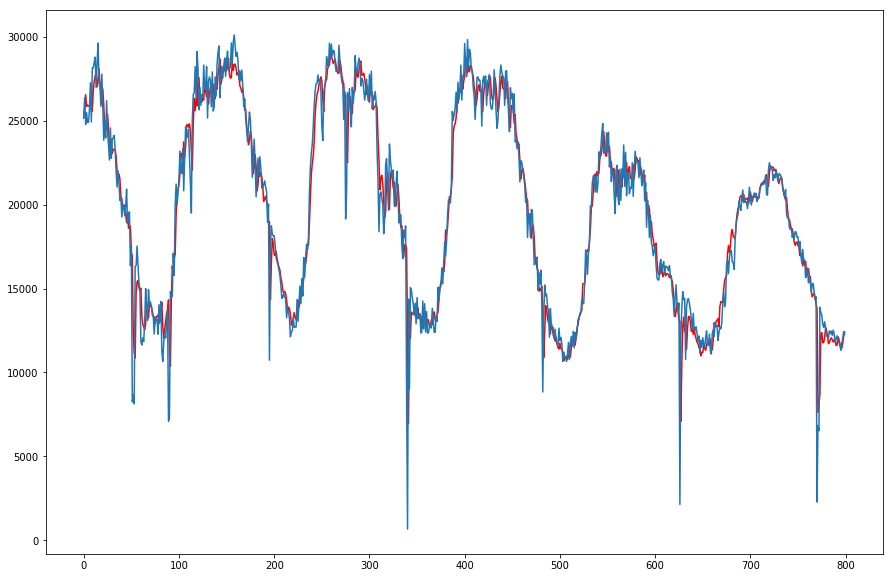

In [284]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_en_t, color = "red")
plt.plot(Y_t)

In [285]:
y_pred_en_val = elastic.predict(X_val)

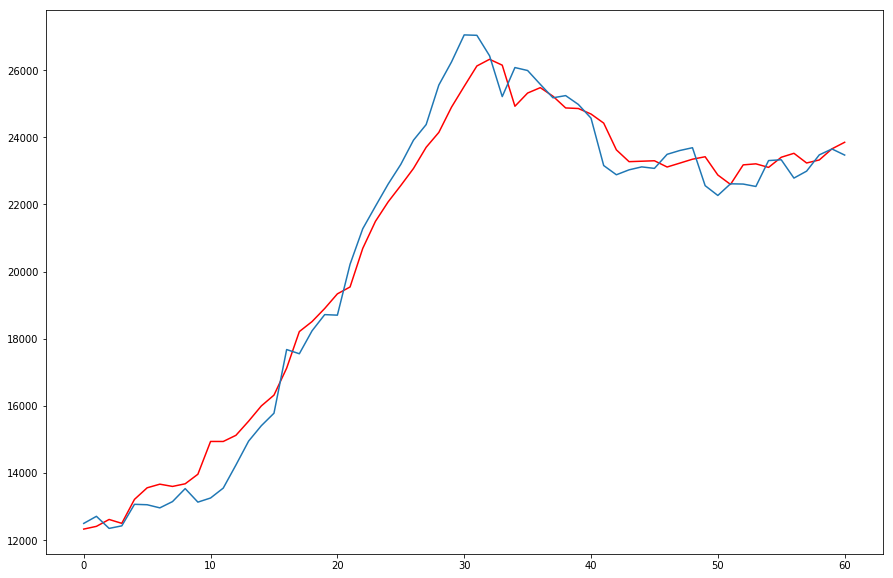

In [286]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_en_val, color = "red")
plt.plot(Y_val)

In [287]:
r2_score(Y_val, y_pred_en_val)

0.9797940246697329

# Support Vector Regressor: 

In [101]:
#prova2 = prova[["taxi_count", "sin_frequency", "shift_24"]]

In [302]:
Y2 = prova["taxi_count"].values
X2 = prova.drop("taxi_count", axis = 1).values

In [303]:
X2.shape

(862, 42)

In [304]:
X_t2 = X2[0:800]
X_val2 = X2[800:862]
Y_t = (Y2[0:800])
Y_val = (Y2[800:862])

In [324]:
x_train, x_test, y_train, y_test = X2[1:662], X2[662:861], Y2[1:662], Y2[662:861]

In [325]:
x_train.shape

(661, 42)

In [326]:
from sklearn.svm import SVR

In [327]:
svc = SVR(kernel = "linear")

In [328]:
svc.fit(x_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [329]:
svc_pred = svc.predict(x_train)

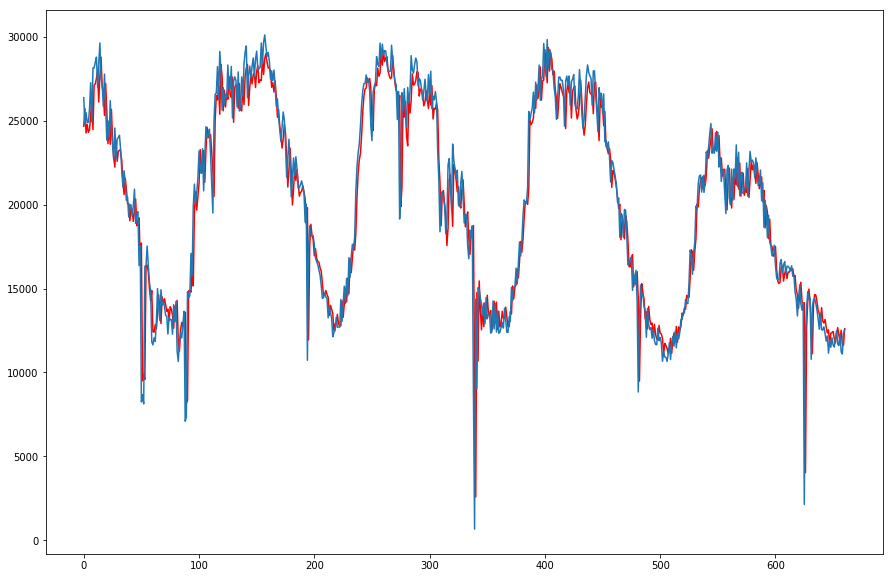

In [330]:
plt.figure(figsize = (15,10))
plt.plot(svc_pred, color = "red")
plt.plot(y_train)

In [331]:
r2_score(y_train,svc_pred)

0.9156056209112865

In [332]:
svc_pred_t = svc.predict(x_test)

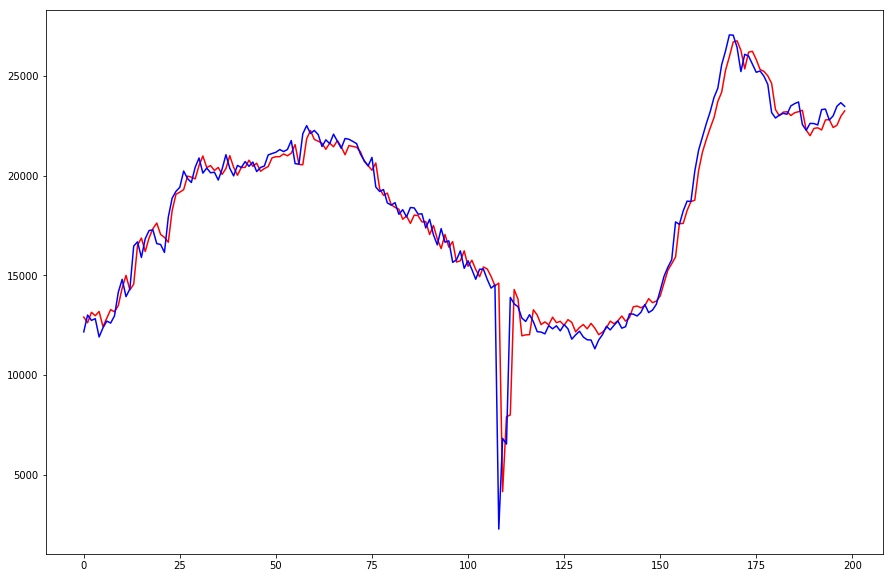

In [333]:
plt.figure(figsize = (15,10))
plt.plot(svc_pred_t, color = "red")
plt.plot(y_test, color = "blue")

In [334]:
r2_score(y_test,svc_pred_t)

0.9352575279197533

 # Ridge

In [335]:
from sklearn.linear_model import Ridge

In [336]:
alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,10] #alpha corrispone a lambda

for alpha in alphas:
    print("Alpha="+str(alpha))
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    overfit_eval(ridge, (x_train, x_test),(y_train, y_test))

Alpha=0.0001
Train set:  MSE=2403597.8462476637 R2=0.9325153534110728
Test set:  MSE=1835381.4189474382 R2=0.9108538341297613
Alpha=0.001
Train set:  MSE=2404101.619487699 R2=0.9325012092150635
Test set:  MSE=1824778.7908229847 R2=0.9113688135425881
Alpha=0.01
Train set:  MSE=2409551.353404777 R2=0.93234819968896
Test set:  MSE=1781692.8767314833 R2=0.9134615360713335
Alpha=0.1
Train set:  MSE=2419004.4546946897 R2=0.9320827895660833
Test set:  MSE=1751336.8367643282 R2=0.9149359568898833
Alpha=1
Train set:  MSE=2421192.3353328677 R2=0.9320213615065279
Test set:  MSE=1731779.9780384356 R2=0.915885851529701
Alpha=10
Train set:  MSE=2426033.1121414374 R2=0.9318854493727023
Test set:  MSE=1616242.6802137957 R2=0.9214976044927343


# Lasso

In [337]:
from sklearn.linear_model import Lasso

In [338]:
alphas = [0.00001, 0.0001, 0.001, 0.01 ,0.1 ,1,10] #alpha corrispone a lambda

for alpha in alphas:
    print("Alpha="+str(alpha))
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)

    overfit_eval(lasso, (x_train, x_test),(y_train, y_test))

Alpha=1e-05
Train set:  MSE=2420321.453678823 R2=0.9320458128267585
Test set:  MSE=1681504.883637448 R2=0.9183277591671787
Alpha=0.0001
Train set:  MSE=2420321.469999885 R2=0.9320458123685199
Test set:  MSE=1681572.7572590904 R2=0.9183244624828653
Alpha=0.001
Train set:  MSE=2420321.6355837593 R2=0.9320458077195022
Test set:  MSE=1682311.731859846 R2=0.9182885698059248
Alpha=0.01
Train set:  MSE=2420325.031041465 R2=0.9320457123868892
Test set:  MSE=1695413.9677434165 R2=0.9176521821421455
Alpha=0.1
Train set:  MSE=2420477.4473368484 R2=0.9320414330687643
Test set:  MSE=1781405.3815591233 R2=0.9134754999766327
Alpha=1
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.9488985145 R2=0.9143841372101541
Alpha=10
Train set:  MSE=2438812.390702442 R2=0.9315266517898633
Test set:  MSE=1592890.0753121194 R2=0.9226318620201212


C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

In [339]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t.shape[0]-1)
y_ = []
y_pred = []

for train_index, test_index in tscv.split(X_t):
    if train_index.shape[0] > 100:
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t[train_index], X[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t[train_index], Y_t[test_index]
        lasso = Lasso(alpha=10)
        lasso.fit(X_train, y_train)
        print(overfit_eval(lasso, (X_train, X_test),(y_train, y_test)))
    #overfit_eval(lasso, (X_train, X_test),(y_train, y_test))
        y_pred.append(elastic.predict(X_test))
        y_.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2923590.0496124625 R2=0.9166783561646514
Test set:  MSE=2235277.7050351347 R2=0.0
None
Train set:  MSE=2903625.0147624947 R2=0.9168641805584166
Test set:  MSE=389402.53868469276 R2=0.0
None
Train set:  MSE=2878454.481840418 R2=0.9170203111736165
Test set:  MSE=960358.5893324899 R2=0.0
None
Train set:  MSE=2867034.8710471666 R2=0.9167438754358159
Test set:  MSE=5129688.222475467 R2=0.0
None
Train set:  MSE=2889716.5054126126 R2=0.9157222567792108
Test set:  MSE=8050841.928392828 R2=0.0
None
Train set:  MSE=2879881.4673867337 R2=0.9152858368524618
Test set:  MSE=3602272.746121956 R2=0.0
None
Train set:  MSE=2891220.4538788055 R2=0.9144973603526654
Test set:  MSE=3711547.4519834975 R2=0.0
None
Train set:  MSE=2892335.412918812 R2=0.9143957591805694
Test set:  MSE=15534.74891502717 R2=0.0
None
Train set:  MSE=2866126.6480923537 R2=0.9149340008757789
Test set:  MSE=467672.39370168536 R2=0.0
None
Train set:  MSE=2848151.4727357696 R2=0.9152536271794942
Test set:  MSE=780889.2

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2775560.0367780575 R2=0.924324954553266
Test set:  MSE=321405.2773583591 R2=0.0
None
Train set:  MSE=2761988.619789763 R2=0.9247653402181812
Test set:  MSE=1671611.311100644 R2=0.0
None
Train set:  MSE=2749715.7798852082 R2=0.9253516160742359
Test set:  MSE=1115910.1979927565 R2=0.0
None
Train set:  MSE=2733641.228273232 R2=0.9261192184477249
Test set:  MSE=172293.33362455806 R2=0.0
None
Train set:  MSE=2718621.583902012 R2=0.9266270603999371
Test set:  MSE=318737.02325342374 R2=0.0
None
Train set:  MSE=2700989.7868878185 R2=0.9272062034851968
Test set:  MSE=275898.6940808956 R2=0.0
None
Train set:  MSE=2683551.8945313417 R2=0.9277865085862018
Test set:  MSE=3288754.8085240372 R2=0.0
None
Train set:  MSE=2675661.546598816 R2=0.9283648865661248
Test set:  MSE=169436.7062688584 R2=0.0
None
Train set:  MSE=2661248.6862538387 R2=0.9288749974455202
Test set:  MSE=2296179.220971641 R2=0.0
None
Train set:  MSE=2654536.29993632 R2=0.9293949937314647
Test set:  MSE=1174855.71283

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2361510.1325966488 R2=0.9338215729002906
Test set:  MSE=1012675.5393497901 R2=0.0
None
Train set:  MSE=2356422.4572706157 R2=0.9338989611297185
Test set:  MSE=363990.7373043685 R2=0.0
None
Train set:  MSE=2347745.0581339435 R2=0.9339885180575926
Test set:  MSE=776223.7397318218 R2=0.0
None
Train set:  MSE=2340769.585584652 R2=0.9339869162670092
Test set:  MSE=4265.630562429864 R2=0.0
None
Train set:  MSE=2331157.1798546156 R2=0.9340759235281939
Test set:  MSE=863383.8830975997 R2=0.0
None
Train set:  MSE=2325902.7819419308 R2=0.9340070271406262
Test set:  MSE=3450608.178145625 R2=0.0
None
Train set:  MSE=2325812.888104212 R2=0.9337311753072295
Test set:  MSE=3652310.09745724 R2=0.0
None
Train set:  MSE=2329008.1059433254 R2=0.9333769182103249
Test set:  MSE=2830754.688582671 R2=0.0
None
Train set:  MSE=2332114.6607165593 R2=0.9330484608241408
Test set:  MSE=2241592.6494785575 R2=0.0
None
Train set:  MSE=2333442.376805989 R2=0.9327922779020874
Test set:  MSE=4617587.6988

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2267736.281730916 R2=0.9359003115916438
Test set:  MSE=116214.81504093816 R2=0.0
None
Train set:  MSE=2259803.5201741457 R2=0.9361674350260643
Test set:  MSE=4673.267139410447 R2=0.0
None
Train set:  MSE=2251602.7401706665 R2=0.9364386568835624
Test set:  MSE=6180.996342739639 R2=0.0
None
Train set:  MSE=2243408.4215600844 R2=0.9367097439076579
Test set:  MSE=2528290.909614708 R2=0.0
None
Train set:  MSE=2242759.1072468185 R2=0.9369109356156333
Test set:  MSE=95741.31709300686 R2=0.0
None
Train set:  MSE=2235264.2378645856 R2=0.9372069228738936
Test set:  MSE=355905.35916543595 R2=0.0
None
Train set:  MSE=2228731.2773065153 R2=0.9374086914536357
Test set:  MSE=300639.89849978144 R2=0.0
None
Train set:  MSE=2222222.963989193 R2=0.9375720766309814
Test set:  MSE=100706.88936044737 R2=0.0
None
Train set:  MSE=2214879.921723688 R2=0.9377433318716702
Test set:  MSE=6429247.446103566 R2=0.0
None
Train set:  MSE=2232027.9267994836 R2=0.9371064929544524
Test set:  MSE=116822.20

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2423124.661050089 R2=0.9305615020800239
Test set:  MSE=1674005.3378740277 R2=0.0
None
Train set:  MSE=2422600.7767636837 R2=0.9305009831791171
Test set:  MSE=2708374.9870506157 R2=0.0
None
Train set:  MSE=2426103.648823057 R2=0.9302845946253145
Test set:  MSE=253332.28402816353 R2=0.0
None
Train set:  MSE=2419896.1560996366 R2=0.9303783458827335
Test set:  MSE=125490.10157044893 R2=0.0
None
Train set:  MSE=2411543.4674866144 R2=0.9305827056341567
Test set:  MSE=1036841.3913244149 R2=0.0
None
Train set:  MSE=2408867.7405249863 R2=0.9305612414471834
Test set:  MSE=1158098.2863053253 R2=0.0
None
Train set:  MSE=2406133.495839605 R2=0.9305206125158044
Test set:  MSE=999550.9780221366 R2=0.0
None
Train set:  MSE=2399569.7764992574 R2=0.9306921675267946
Test set:  MSE=909778.0703032016 R2=0.0
None
Train set:  MSE=2396235.7898665373 R2=0.930689264346798
Test set:  MSE=872914.7116312805 R2=0.0
None
Train set:  MSE=2389727.836317122 R2=0.930872937723317
Test set:  MSE=3924801.32

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2495157.2414039522 R2=0.9238906904598856
Test set:  MSE=77116.40876195002 R2=0.0
None
Train set:  MSE=2487860.789077329 R2=0.9238816643878056
Test set:  MSE=650795.5627267516 R2=0.0
None
Train set:  MSE=2481710.6973339105 R2=0.9238362663872404
Test set:  MSE=3137946.2811631826 R2=0.0
None
Train set:  MSE=2483973.892229509 R2=0.9235662041676964
Test set:  MSE=629428.5943709589 R2=0.0
None
Train set:  MSE=2477638.139246004 R2=0.9235647358775659
Test set:  MSE=997609.376639814 R2=0.0
None
Train set:  MSE=2473207.226609853 R2=0.9234743702962325
Test set:  MSE=799893.7207335305 R2=0.0
None
Train set:  MSE=2468241.984864711 R2=0.9233960350698998
Test set:  MSE=1777198.5881519502 R2=0.0
None
Train set:  MSE=2465559.6253511677 R2=0.9232696629441642
Test set:  MSE=3076429.8131662174 R2=0.0
None
Train set:  MSE=2466152.864974704 R2=0.923094106961167
Test set:  MSE=33095.64615643033 R2=0.0
None
Train set:  MSE=2458832.7070740717 R2=0.9231446335417751
Test set:  MSE=19852.881581484

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=3181623.2815232114 R2=0.9077627181917809
Test set:  MSE=634663.9769201134 R2=0.0
None
Train set:  MSE=3174762.67733264 R2=0.9082114451085888
Test set:  MSE=149282.19133524768 R2=0.0
None
Train set:  MSE=3166456.2402299475 R2=0.9086902109097806
Test set:  MSE=275654.7259118359 R2=0.0
None
Train set:  MSE=3157964.455669485 R2=0.9093139152734879
Test set:  MSE=679.4249626882555 R2=0.0
None
Train set:  MSE=3149139.305803443 R2=0.9099281263937111
Test set:  MSE=4487902.132763892 R2=0.0
None
Train set:  MSE=3153274.645481951 R2=0.909943881781632
Test set:  MSE=497017.2946288011 R2=0.0
None
Train set:  MSE=3145318.5044023134 R2=0.9104948718165148
Test set:  MSE=2532086.290318238 R2=0.0
None
Train set:  MSE=3144360.3380908626 R2=0.9106645688107893
Test set:  MSE=602291.2292473534 R2=0.0
None
Train set:  MSE=3136619.6019086805 R2=0.9112183981611518
Test set:  MSE=1748038.6757478858 R2=0.0
None
Train set:  MSE=3133241.4637025017 R2=0.9114965552383099
Test set:  MSE=633643.8096955

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2912858.488624035 R2=0.9189073440022073
Test set:  MSE=308332.0409850746 R2=0.0
None
Train set:  MSE=2906469.4042913476 R2=0.919213148895467
Test set:  MSE=97527.92033697064 R2=0.0
None
Train set:  MSE=2899642.6450678813 R2=0.9194506496849354
Test set:  MSE=19296.79380958068 R2=0.0
None
Train set:  MSE=2892662.723298812 R2=0.9196849235912326
Test set:  MSE=555344.8010289074 R2=0.0
None
Train set:  MSE=2887019.2505751657 R2=0.9198148150924446
Test set:  MSE=428343.4008996091 R2=0.0
None
Train set:  MSE=2880959.4379111943 R2=0.91992352702761
Test set:  MSE=2731364.252133625 R2=0.0
None
Train set:  MSE=2880709.609563446 R2=0.9198077323585743
Test set:  MSE=389782.09780690144 R2=0.0
None
Train set:  MSE=2874469.2773410077 R2=0.9199197101255423
Test set:  MSE=1618804.2753037887 R2=0.0
None
Train set:  MSE=2870911.3234889284 R2=0.9200284626610021
Test set:  MSE=313966.11324773746 R2=0.0
None
Train set:  MSE=2864645.1585361273 R2=0.9202121249071048
Test set:  MSE=10344.2064736

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2813244.434616872 R2=0.9212559881515162
Test set:  MSE=1331949.321719491 R2=0.0
None
Train set:  MSE=2810115.453675792 R2=0.9212444734691821
Test set:  MSE=781131.4156751293 R2=0.0
None
Train set:  MSE=2805960.079937396 R2=0.9212615515062007
Test set:  MSE=3724.6169518374163 R2=0.0
None
Train set:  MSE=2799461.9216003707 R2=0.9213797667377502
Test set:  MSE=1224327.667507671 R2=0.0
None
Train set:  MSE=2795178.068984711 R2=0.9215251090877647
Test set:  MSE=713447.4449616496 R2=0.0
None
Train set:  MSE=2790936.6035851114 R2=0.9216019954667075
Test set:  MSE=2982768.5130165787 R2=0.0
None
Train set:  MSE=2791877.048751199 R2=0.9214684618779001
Test set:  MSE=3379736.3502183575 R2=0.0
None
Train set:  MSE=2793677.781500422 R2=0.9212777693421118
Test set:  MSE=233607.59898556053 R2=0.0
None
Train set:  MSE=2787923.924462826 R2=0.9213169351444513
Test set:  MSE=204992.87954985158 R2=0.0
None
Train set:  MSE=2781926.8441193188 R2=0.9214158795430992
Test set:  MSE=1119605.3998

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2646679.4058428225 R2=0.921646433222235
Test set:  MSE=6868818.308585631 R2=0.0
None
Train set:  MSE=2653730.2801635265 R2=0.9214184447376984
Test set:  MSE=1293327.5666153885 R2=0.0
None
Train set:  MSE=2650503.4306175425 R2=0.9214914131810072
Test set:  MSE=484298.5695993685 R2=0.0
None
Train set:  MSE=2645773.7976584425 R2=0.9215939180338794
Test set:  MSE=2576.4912055663967 R2=0.0
None
Train set:  MSE=2640287.7595943445 R2=0.9217125557921989
Test set:  MSE=3489741.4297959763 R2=0.0
None
Train set:  MSE=2637983.8818913763 R2=0.9218509607615567
Test set:  MSE=463944.5729599975 R2=0.0
None
Train set:  MSE=2634890.3989104996 R2=0.9219471279834233
Test set:  MSE=169095.82998142642 R2=0.0
None
Train set:  MSE=2628960.128693946 R2=0.9221658525249754
Test set:  MSE=508218.84584194416 R2=0.0
None
Train set:  MSE=2625748.359094791 R2=0.9222552415568561
Test set:  MSE=2804440.7585667796 R2=0.0
None
Train set:  MSE=2622844.0654446627 R2=0.9224561780320466
Test set:  MSE=2717828

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2640020.855797745 R2=0.9244234494931617
Test set:  MSE=228540.20648799968 R2=0.0
None
Train set:  MSE=2635566.86761549 R2=0.9247484075053386
Test set:  MSE=143541.20292044512 R2=0.0
None
Train set:  MSE=2630263.5407706955 R2=0.9251468156418186
Test set:  MSE=29675.962983431873 R2=0.0
None
Train set:  MSE=2624943.233272632 R2=0.9255602099118545
Test set:  MSE=368.9196855253919 R2=0.0
None
Train set:  MSE=2619720.7647230993 R2=0.925966603984729
Test set:  MSE=1239144.7068250338 R2=0.0
None
Train set:  MSE=2617661.408391924 R2=0.9262017954716687
Test set:  MSE=74543.54090196113 R2=0.0
None
Train set:  MSE=2612368.5911400467 R2=0.9265810423828845
Test set:  MSE=139751.80214658723 R2=0.0
None
Train set:  MSE=2607841.6079239496 R2=0.926919630087979
Test set:  MSE=6249.180201096633 R2=0.0
None
Train set:  MSE=2602651.0829734807 R2=0.9272989323288255
Test set:  MSE=813704.3124593392 R2=0.0
None
Train set:  MSE=2598321.4917494375 R2=0.9277366755846814
Test set:  MSE=29260.909958

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2547380.0924858414 R2=0.9316661388467723
Test set:  MSE=1183784.1767653509 R2=0.0
None
Train set:  MSE=2543735.793689267 R2=0.9319640728106477
Test set:  MSE=73410.31417620754 R2=0.0
None
Train set:  MSE=2539238.6520611406 R2=0.9322212270151061
Test set:  MSE=396447.8636615199 R2=0.0
None
Train set:  MSE=2534609.9257143247 R2=0.9325041895067802
Test set:  MSE=660814.3340566261 R2=0.0
None
Train set:  MSE=2530927.7260535853 R2=0.9327343229187809
Test set:  MSE=107632.44892351324 R2=0.0
None
Train set:  MSE=2526304.3716155784 R2=0.9329431983313109
Test set:  MSE=439417.53635468084 R2=0.0
None
Train set:  MSE=2522180.464364654 R2=0.9331379585801572
Test set:  MSE=193863.71170073765 R2=0.0
None
Train set:  MSE=2517648.0739166136 R2=0.9333214312850013
Test set:  MSE=347574.3956407826 R2=0.0
None
Train set:  MSE=2513355.476248424 R2=0.9334967407824739
Test set:  MSE=12645.623133923958 R2=0.0
None
Train set:  MSE=2508685.242798109 R2=0.9336428642749265
Test set:  MSE=3234343.0

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2488642.405736234 R2=0.9336195228195001
Test set:  MSE=1036372.2126764804 R2=0.0
None
Train set:  MSE=2485753.8744417327 R2=0.933572773957002
Test set:  MSE=130727.21359784978 R2=0.0
None
Train set:  MSE=2481401.1882016747 R2=0.9335670676628605
Test set:  MSE=40132.056469817704 R2=0.0
None
Train set:  MSE=2477036.2809131905 R2=0.9335624804217908
Test set:  MSE=2483502.035604409 R2=0.0
None
Train set:  MSE=2477545.1504245372 R2=0.9334252067760684
Test set:  MSE=3716.4036920708104 R2=0.0
None
Train set:  MSE=2473005.847287208 R2=0.9334255428312881
Test set:  MSE=2598028.312708322 R2=0.0
None
Train set:  MSE=2473025.0265545207 R2=0.9333016578342936
Test set:  MSE=349325.6340843673 R2=0.0
None
Train set:  MSE=2469134.764703778 R2=0.9332837090643153
Test set:  MSE=1053855.4067340046 R2=0.0
None
Train set:  MSE=2466524.460245563 R2=0.9332471772113362
Test set:  MSE=69703.1799015443 R2=0.0
None
Train set:  MSE=2462188.1339061195 R2=0.9332525531605984
Test set:  MSE=81041.03714

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2435384.52258627 R2=0.933013138946785
Test set:  MSE=25.456360704005903 R2=0.0
None
Train set:  MSE=2431036.0175673445 R2=0.9330229304493531
Test set:  MSE=2352641.9641241278 R2=0.0
None
Train set:  MSE=2430589.6343925917 R2=0.9329148440305899
Test set:  MSE=13259.437042670052 R2=0.0
None
Train set:  MSE=2426286.2204949236 R2=0.9329170334809226
Test set:  MSE=228307.75210570244 R2=0.0
None
Train set:  MSE=2422430.9523458765 R2=0.9329061515428947
Test set:  MSE=2484260.881404926 R2=0.0
None
Train set:  MSE=2422641.035048897 R2=0.9327803995971379
Test set:  MSE=3846676.982612158 R2=0.0
None
Train set:  MSE=2425626.8174355375 R2=0.9325848247846406
Test set:  MSE=2672848.2507515675 R2=0.0
None
Train set:  MSE=2425181.744218935 R2=0.9324805680396616
Test set:  MSE=288077.3095276507 R2=0.0
None
Train set:  MSE=2421391.893960315 R2=0.9324716618751877
Test set:  MSE=3355076.552398488 R2=0.0
None
Train set:  MSE=2422597.3197284075 R2=0.9323188569503579
Test set:  MSE=1143113.580

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2413422.592166746 R2=0.9313138502475028
Test set:  MSE=3063597.316592879 R2=0.0
None
Train set:  MSE=2414385.0068841884 R2=0.931166982713975
Test set:  MSE=602938.8117448958 R2=0.0
None
Train set:  MSE=2411355.808122068 R2=0.9311335773501446
Test set:  MSE=504970.91321090545 R2=0.0
None
Train set:  MSE=2408250.5187869635 R2=0.9311026540083945
Test set:  MSE=762005.0933558904 R2=0.0
None
Train set:  MSE=2405265.6604983523 R2=0.9310760167439673
Test set:  MSE=4295773.163247873 R2=0.0
None
Train set:  MSE=2408609.8103002254 R2=0.9308615135479585
Test set:  MSE=328532.74145429523 R2=0.0
None
Train set:  MSE=2404828.2576517276 R2=0.9308544869089975
Test set:  MSE=872051.420036854 R2=0.0
None
Train set:  MSE=2401890.953509733 R2=0.9308356702477026
Test set:  MSE=188642.6949816794 R2=0.0
None
Train set:  MSE=2398164.807990465 R2=0.9308316659098934
Test set:  MSE=71425.28897920281 R2=0.0
None
Train set:  MSE=2394228.3373506702 R2=0.9308354223088724
Test set:  MSE=53106.70185984

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2373902.3176135556 R2=0.9302928356102258
Test set:  MSE=599401.2025228946 R2=0.0
None
Train set:  MSE=2371063.1766629904 R2=0.9302606455691629
Test set:  MSE=362339.4647956903 R2=0.0
None
Train set:  MSE=2367648.2332935156 R2=0.930250995564009
Test set:  MSE=2839058.331834896 R2=0.0
None
Train set:  MSE=2367987.595251227 R2=0.9301545906219502
Test set:  MSE=268512.66881219874 R2=0.0
None
Train set:  MSE=2364488.5664450023 R2=0.9301500692392165
Test set:  MSE=1596593.3860236844 R2=0.0
None
Train set:  MSE=2363040.1837398745 R2=0.9301122753257041
Test set:  MSE=632736.0404256539 R2=0.0
None
Train set:  MSE=2360099.336405091 R2=0.9301249895704237
Test set:  MSE=927149.3245359432 R2=0.0
None
Train set:  MSE=2357722.9466824546 R2=0.9301355225571597
Test set:  MSE=10100.708537915712 R2=0.0
None
Train set:  MSE=2353864.01090726 R2=0.9301817269186294
Test set:  MSE=172.9604630179253 R2=0.0
None
Train set:  MSE=2349994.795361503 R2=0.9302205162953616
Test set:  MSE=1398764.96705

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2328970.722774188 R2=0.930630917565937
Test set:  MSE=831968.7662477477 R2=0.0
None
Train set:  MSE=2326313.788850203 R2=0.9306652040814405
Test set:  MSE=816592.7522484105 R2=0.0
None
Train set:  MSE=2323709.9439401324 R2=0.9306924933192341
Test set:  MSE=8976.056214619004 R2=0.0
None
Train set:  MSE=2319969.873266198 R2=0.9307782931516251
Test set:  MSE=546448.2981114965 R2=0.0
None
Train set:  MSE=2317008.247381272 R2=0.9308241850026285
Test set:  MSE=304625.3753497394 R2=0.0
None
Train set:  MSE=2313684.7106616106 R2=0.9308815933872923
Test set:  MSE=231756.8985574663 R2=0.0
None
Train set:  MSE=2310319.9877714464 R2=0.9309426926661561
Test set:  MSE=351888.40904802 R2=0.0
None
Train set:  MSE=2307097.094615331 R2=0.931005043618117
Test set:  MSE=37.20276027582838 R2=0.0
None
Train set:  MSE=2303398.3827408487 R2=0.9310721732836247
Test set:  MSE=705559.566217912 R2=0.0
None
Train set:  MSE=2300646.4516793857 R2=0.931131139528909
Test set:  MSE=228545.32963116633 R2

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2277669.379767213 R2=0.9320512902075069
Test set:  MSE=130807176.6351656 R2=0.0
None
Train set:  MSE=2455452.823312991 R2=0.9278249835348948
Test set:  MSE=33877656.17238361 R2=0.0
None
Train set:  MSE=2501691.7410159195 R2=0.9265970991907532
Test set:  MSE=11701553.104532443 R2=0.0
None
Train set:  MSE=2516202.1521702595 R2=0.9262181049857499
Test set:  MSE=5698165.278968814 R2=0.0
None
Train set:  MSE=2519962.321861978 R2=0.9261101560380179
Test set:  MSE=379624.1114187461 R2=0.0
None
Train set:  MSE=2516549.4503623466 R2=0.9262326016031102
Test set:  MSE=3670373.880680484 R2=0.0
None
Train set:  MSE=2517683.9940810036 R2=0.9262174880641046
Test set:  MSE=5041852.525078245 R2=0.0
None
Train set:  MSE=2520762.0706356307 R2=0.9263453673059951
Test set:  MSE=4950536.223382973 R2=0.0
None
Train set:  MSE=2524191.604981095 R2=0.9262830069386337
Test set:  MSE=1717187.892700187 R2=0.0
None
Train set:  MSE=2522976.6890037614 R2=0.9263378864346271
Test set:  MSE=649596.053869

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2491801.545457978 R2=0.927843797301588
Test set:  MSE=616.0009665730271 R2=0.0
None
Train set:  MSE=2487993.641743062 R2=0.9280606102649662
Test set:  MSE=187747.02251061462 R2=0.0
None
Train set:  MSE=2484310.618729862 R2=0.9282973044293459
Test set:  MSE=21419.638696330654 R2=0.0
None
Train set:  MSE=2480586.370360075 R2=0.928516427150809
Test set:  MSE=752841.460155902 R2=0.0
None
Train set:  MSE=2477664.1494640037 R2=0.9287683114910322
Test set:  MSE=176631.83673616854 R2=0.0
None
Train set:  MSE=2474264.6721222647 R2=0.928988440217622
Test set:  MSE=58395.296218190524 R2=0.0
None
Train set:  MSE=2470530.036132301 R2=0.92923876237065
Test set:  MSE=342248.9675651543 R2=0.0
None
Train set:  MSE=2467509.1602720064 R2=0.9294359295253446
Test set:  MSE=237573.03577859417 R2=0.0
None
Train set:  MSE=2464144.8426842457 R2=0.9296641584692745
Test set:  MSE=222139.30840566498 R2=0.0
None
Train set:  MSE=2460809.981088489 R2=0.9298960670245731
Test set:  MSE=29189.3409420642

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2438780.370208029 R2=0.9314224109408659
Test set:  MSE=4489.510006679524 R2=0.0
None
Train set:  MSE=2435144.222397457 R2=0.9315962967600602
Test set:  MSE=2253775.9642249905 R2=0.0
None
Train set:  MSE=2435551.3557601715 R2=0.9316742298987863
Test set:  MSE=174794.01823952276 R2=0.0
None
Train set:  MSE=2432375.3260137215 R2=0.9318140879538981
Test set:  MSE=1034961.3965220604 R2=0.0
None
Train set:  MSE=2430376.568856174 R2=0.9319314592662794
Test set:  MSE=872725.6595654176 R2=0.0
None
Train set:  MSE=2427958.195149309 R2=0.9320561370270048
Test set:  MSE=3807314.052990287 R2=0.0
None
Train set:  MSE=2429669.957312917 R2=0.9321056209666126
Test set:  MSE=865161.8051265327 R2=0.0
None
Train set:  MSE=2427298.621699805 R2=0.9322470230042527
Test set:  MSE=3018728.6112236665 R2=0.0
None
Train set:  MSE=2429043.395106286 R2=0.9322578461703309
Test set:  MSE=3973441.307865679 R2=0.0
None
Train set:  MSE=2432172.0804479495 R2=0.9322336599662984
Test set:  MSE=2310423.66715

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2423475.6785699655 R2=0.9323356175543941
Test set:  MSE=222391.22057878677 R2=0.0
None
Train set:  MSE=2420401.885810437 R2=0.9323526363179943
Test set:  MSE=172124.22314628135 R2=0.0
None
Train set:  MSE=2417214.760761368 R2=0.9323658604929328
Test set:  MSE=978778.2729270464 R2=0.0
None
Train set:  MSE=2415589.405854528 R2=0.9323350054564776
Test set:  MSE=3628305.6809549574 R2=0.0
None
Train set:  MSE=2418083.646507834 R2=0.9322010636862257
Test set:  MSE=2215474.486681086 R2=0.0
None
Train set:  MSE=2418394.4531211928 R2=0.9321290882094874
Test set:  MSE=3118572.9351479616 R2=0.0
None
Train set:  MSE=2420077.5757581173 R2=0.932026932430438
Test set:  MSE=31858.04468789002 R2=0.0
None
Train set:  MSE=2416557.2556050094 R2=0.9320403794560614
Test set:  MSE=63312.394286355106 R2=0.0
None
Train set:  MSE=2413081.982668681 R2=0.9320434977542662
Test set:  MSE=2207.958904036927 R2=0.0
None
Train set:  MSE=2409590.6697468627 R2=0.9320452658978488
Test set:  MSE=20291.13714

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2391295.810541304 R2=0.9319763452083191
Test set:  MSE=248713.0690835626 R2=0.0
None
Train set:  MSE=2388261.5750902086 R2=0.9319646245326478
Test set:  MSE=3233.8369650935883 R2=0.0
None
Train set:  MSE=2384872.372680653 R2=0.9319634529077055
Test set:  MSE=39544.60641867013 R2=0.0
None
Train set:  MSE=2381564.4056604174 R2=0.9319600656587919
Test set:  MSE=20781.13137020763 R2=0.0
None
Train set:  MSE=2378234.6887792037 R2=0.9319575763704562
Test set:  MSE=374950.3272661538 R2=0.0
None
Train set:  MSE=2375426.670876924 R2=0.9319407563537514
Test set:  MSE=128411.08976981563 R2=0.0
None
Train set:  MSE=2372207.2279292815 R2=0.9319357304147137
Test set:  MSE=691961.2385299087 R2=0.0
None
Train set:  MSE=2369704.8744964097 R2=0.9319126103387724
Test set:  MSE=114428.92509079356 R2=0.0
None
Train set:  MSE=2366555.712827083 R2=0.9319061128180004
Test set:  MSE=195308.7896896832 R2=0.0
None
Train set:  MSE=2363539.188685458 R2=0.9318959532425719
Test set:  MSE=148390.03723

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2344294.0544075477 R2=0.9318758224262398
Test set:  MSE=6659.116616761386 R2=0.0
None
Train set:  MSE=2341048.7497801855 R2=0.931874251207306
Test set:  MSE=7325.299152983398 R2=0.0
None
Train set:  MSE=2337811.8677386846 R2=0.9318728246953438
Test set:  MSE=38437.115429512545 R2=0.0
None
Train set:  MSE=2334619.1153321327 R2=0.9318723087453291
Test set:  MSE=4616.73255801159 R2=0.0
None
Train set:  MSE=2331391.971857334 R2=0.9318734241871811
Test set:  MSE=9292.799195095105 R2=0.0
None
Train set:  MSE=2328180.22084219 R2=0.9318746986365396
Test set:  MSE=40.12348248153059 R2=0.0
None
Train set:  MSE=2324966.595632136 R2=0.9318771174122527
Test set:  MSE=44171.92237738013 R2=0.0
None
Train set:  MSE=2321809.342843983 R2=0.931877506613914
Test set:  MSE=15743.963758880265 R2=0.0
None
Train set:  MSE=2318628.231675105 R2=0.9318794810872102
Test set:  MSE=16463.56320258683 R2=0.0
None
Train set:  MSE=2315485.9920745315 R2=0.9318840664793799
Test set:  MSE=1637445.526593109

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2301149.216320086 R2=0.9317896850950953
Test set:  MSE=28424.699368519035 R2=0.0
None
Train set:  MSE=2298066.1109339492 R2=0.9317969354510173
Test set:  MSE=594542.6791594643 R2=0.0
None
Train set:  MSE=2295795.5946240304 R2=0.9317748959035346
Test set:  MSE=38059.79281620323 R2=0.0
None
Train set:  MSE=2292748.2971448717 R2=0.9317788890088186
Test set:  MSE=218769.02821171717 R2=0.0
None
Train set:  MSE=2289978.6474117045 R2=0.9317732130382042
Test set:  MSE=11437.67189489224 R2=0.0
None
Train set:  MSE=2286883.9719038457 R2=0.9317818707308899
Test set:  MSE=3598.656017460549 R2=0.0
None
Train set:  MSE=2283783.643603521 R2=0.931787451031534
Test set:  MSE=36981.95230629859 R2=0.0
None
Train set:  MSE=2280710.7037935522 R2=0.9317897718218866
Test set:  MSE=288768.30891211866 R2=0.0
None
Train set:  MSE=2278115.330319936 R2=0.9317820017578796
Test set:  MSE=61536.63507062671 R2=0.0
None
Train set:  MSE=2275185.070357305 R2=0.9317841027499878
Test set:  MSE=4542.2054823

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2255728.125998489 R2=0.931739452477735
Test set:  MSE=312615.5410100752 R2=0.0
None
Train set:  MSE=2253002.8652381077 R2=0.9317323517193089
Test set:  MSE=4052.1275710114055 R2=0.0
None
Train set:  MSE=2250029.3513868945 R2=0.9317325050809482
Test set:  MSE=259262.86153887262 R2=0.0
None
Train set:  MSE=2247264.7412808826 R2=0.9317311077187828
Test set:  MSE=73705.17797106897 R2=0.0
None
Train set:  MSE=2244333.421499381 R2=0.9317359574276051
Test set:  MSE=4868.918974420436 R2=0.0
None
Train set:  MSE=2241376.8539337777 R2=0.9317407160231885
Test set:  MSE=187020.38065536154 R2=0.0
None
Train set:  MSE=2238626.8385352762 R2=0.9317453506725432
Test set:  MSE=15856.880459650869 R2=0.0
None
Train set:  MSE=2235697.3513326133 R2=0.931753066274951
Test set:  MSE=12599.57913787511 R2=0.0
None
Train set:  MSE=2232802.442058302 R2=0.9317640730443298
Test set:  MSE=672603.9907061565 R2=0.0
None
Train set:  MSE=2230970.1396975676 R2=0.9317375142205045
Test set:  MSE=346123.7686

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2218559.8835829175 R2=0.9317336013085438
Test set:  MSE=22521.584121272135 R2=0.0
None
Train set:  MSE=2215656.2322749426 R2=0.9317595645094429
Test set:  MSE=60696.87800163561 R2=0.0
None
Train set:  MSE=2212802.5400645174 R2=0.9317935213624011
Test set:  MSE=915086.4542619495 R2=0.0
None
Train set:  MSE=2211195.2185163754 R2=0.9317746271038627
Test set:  MSE=427.73320149287446 R2=0.0
None
Train set:  MSE=2208317.888046542 R2=0.9318069017546371
Test set:  MSE=104158.06855767172 R2=0.0
None
Train set:  MSE=2205611.3521163673 R2=0.9318327515564275
Test set:  MSE=1889501.6509378718 R2=0.0
None
Train set:  MSE=2205402.2738730055 R2=0.9318049999053284
Test set:  MSE=274405.7449014506 R2=0.0
None
Train set:  MSE=2203024.8155681333 R2=0.9318411686339128
Test set:  MSE=172.43553071538798 R2=0.0
None
Train set:  MSE=2200172.292444214 R2=0.9318818133672737
Test set:  MSE=1156438.9670206984 R2=0.0
None
Train set:  MSE=2199053.3147944077 R2=0.9318897000819673
Test set:  MSE=36928.

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might wa

Train set:  MSE=2186155.914460837 R2=0.9321642612247111
Test set:  MSE=69050.34077516674 R2=0.0
None
Train set:  MSE=2183473.5138316397 R2=0.9322354777706467
Test set:  MSE=160624.1184779738 R2=0.0
None
Train set:  MSE=2180941.516245287 R2=0.9323149796313436
Test set:  MSE=17039.061982613377 R2=0.0
None
Train set:  MSE=2178150.6824871385 R2=0.9323974741476655
Test set:  MSE=141447808.15933293 R2=0.0
None
Train set:  MSE=2339789.8345556115 R2=0.9282001426255446
Test set:  MSE=28916.108888915573 R2=0.0
None
Train set:  MSE=2336721.6237247647 R2=0.9286956663725163
Test set:  MSE=1072822.4171374275 R2=0.0
None
Train set:  MSE=2334274.3116038362 R2=0.9291856581287707
Test set:  MSE=41673853.73698041 R2=0.0
None
Train set:  MSE=2381217.5261907754 R2=0.9277735937830506
Test set:  MSE=2684424.982864402 R2=0.0
None
Train set:  MSE=2382814.503380301 R2=0.9277482400893312
Test set:  MSE=1607273.7323700704 R2=0.0
None
Train set:  MSE=2382849.344628543 R2=0.9277751924498655
Test set:  MSE=1669253.4

C:\Users\giorgio1\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [340]:
y_pred_lass = lasso.predict(X_t)

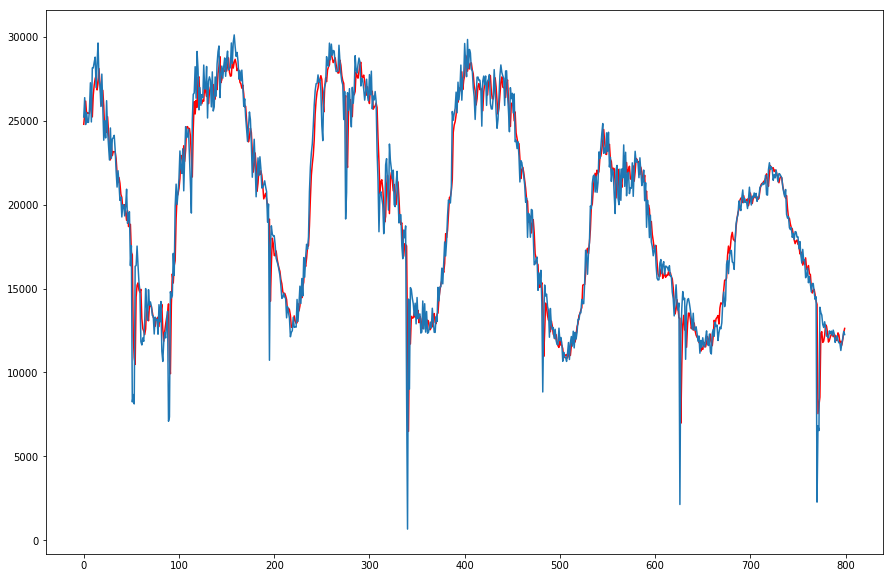

In [341]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_lass, color = "red")
plt.plot(Y_t)

In [342]:
r2_score(Y_t,y_pred_lass)

0.9312932416005563

In [343]:
y_pred_lass_v = lasso.predict(X_val)

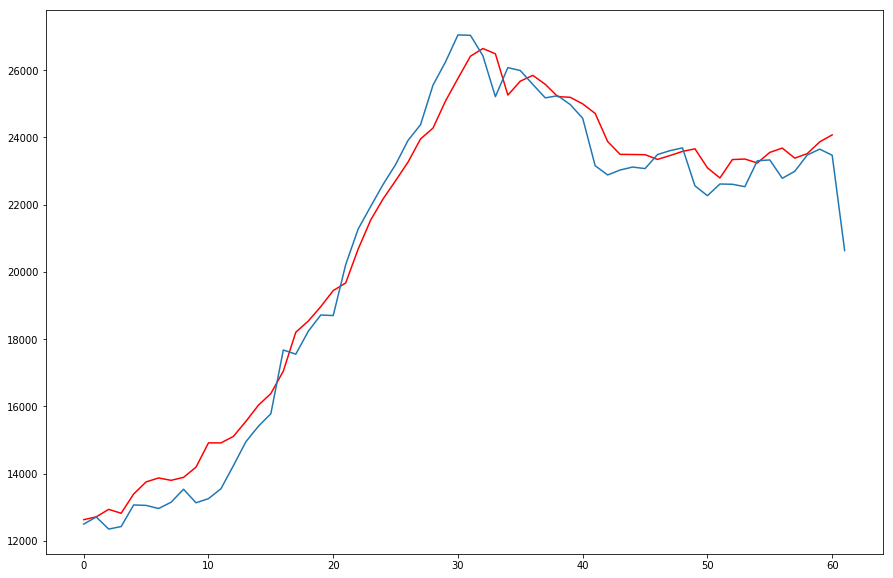

In [344]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_lass_v, color = "red")
plt.plot(Y_val)

In [345]:
r2_score(Y_val,y_pred_lass_v)

ValueError: Found input variables with inconsistent numbers of samples: [62, 61]

# KNN Regressor: 

In [378]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  GridSearchCV

In [379]:
x_train, x_test, y_train, y_test = X2[1:662], X2[662:861], Y2[1:662], Y2[662:861]

In [380]:
knr =  KNeighborsRegressor(n_neighbors=10, metric='euclidean', leaf_size=200)

In [381]:
#??KNeighborsRegressor

In [382]:
knr.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=200, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [383]:
y_pred_knr = knr.predict(x_train)

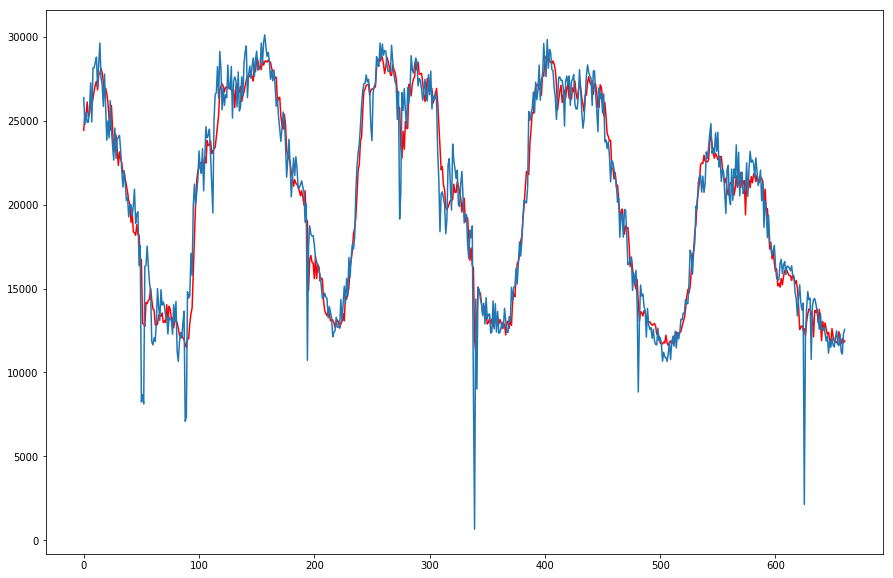

In [384]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_knr, color = "red")
plt.plot(y_train)

In [385]:
r2_score(y_train,y_pred_knr)

0.9355958274042664

In [386]:
y_pred_knr_v = knr.predict(x_test)

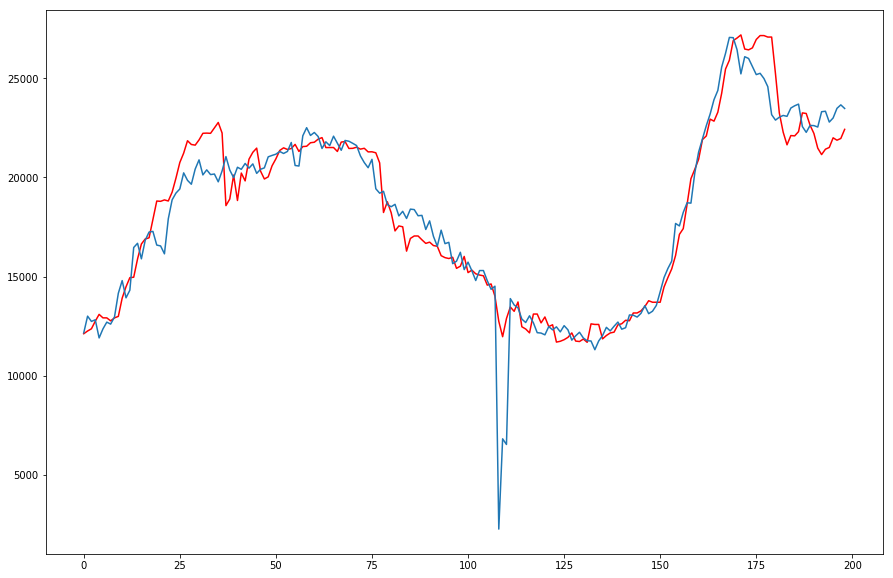

In [387]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_knr_v, color = "red")
plt.plot(y_test)

In [388]:
r2_score(y_test,y_pred_knr_v)

0.9046544631567284